In [1]:
import os, sys
sys.path.append('../functions')

In [2]:
% matplotlib inline
import pandas
import numpy
import matplotlib.pyplot as plt

#Reading data

In [3]:
all_mctracks = pandas.read_csv('Data/MCTrack.csv', delimiter=',')
all_velo_points = pandas.read_csv('Data/vetoPoint.csv', delimiter=',')
all_hits = pandas.read_csv('Data/strawtubesPoint_decoded_hits.csv', delimiter=',')
all_hits['Index'] = all_hits.index
all_hits = all_hits[['Index', 'X', 'Y', 'Z', 'TrackID', 'Time', 'StatNb', 'ViewNb', 'PlaneNb', 'LayerNb', 'StrawNb', 'dist2Wire', 'event', 'k']]
all_hits.head()

,Index,X,Y,Z,TrackID,Time,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,dist2Wire,event,k
0,0,8.883409,-61.202305,-1974.859985,3,232.044861,5,0,0,0,319,0.274822,0,0
1,1,8.858191,-61.225544,-1973.742188,3,232.074081,5,0,0,1,320,0.582455,0,1
2,2,8.824563,-61.256523,-1972.251953,3,232.118286,5,0,1,0,319,0.111252,0,2
3,3,8.632817,-61.432972,-1963.756592,3,232.406479,5,1,0,1,320,0.164412,0,3
4,4,8.573978,-61.487133,-1961.149292,3,232.488541,5,1,1,1,320,0.226827,0,4


# Get reconstructible events

In [4]:
from ReconstructibleTracks import get_reconstractible_tracks

reconstructible_events_test = {}

for event_id in range(2500, 5000, 2):
    
    tracks = get_reconstractible_tracks(event_id, all_hits, all_mctracks, all_velo_points)
    
    if tracks != []:
        reconstructible_events_test[event_id] = tracks

In [5]:
from ReconstructibleTracks import get_reconstractible_tracks

reconstructible_events_train = {}

for event_id in range(2501, 5000, 2):
    
    tracks = get_reconstractible_tracks(event_id, all_hits, all_mctracks, all_velo_points)
    
    if tracks != []:
        reconstructible_events_train[event_id] = tracks

In [6]:
from MarginLinearRegression import *

In [7]:
import UV_views

def get_zx_hits(event, zy_plane_k, zy_plane_b):
    
    stereo_hits = UV_views.modify_for_xz_analysis_1_2(event)
    
    stereo_hits['Wy'] = zy_plane_k * stereo_hits.Wz.values + zy_plane_b
    stereo_hits['Wx'] = (stereo_hits.Wx2.values - stereo_hits.Wx1.values) / (stereo_hits.Wy2.values - stereo_hits.Wy1.values) * \
                        (stereo_hits.Wy.values - stereo_hits.Wy1.values) + stereo_hits.Wx1.values
    
    return stereo_hits#[numpy.abs(stereo_hits.Wx.values) < 300]

In [8]:
from Y_views import *

def get_y_view_data(all_hit_ids, reconstructible_events_ids):
    all_dists = []
    all_dist2wires = []
    all_scores = []
    all_labels = []
    all_ks = []
    all_bs = []
    
    counter = 0


    for event_id in reconstructible_events_ids:
        
        # get all event hits
        event = all_hits[all_hits['event'] == event_id]
        
        # get hits in y_views
        event_y = modify_for_yz_analysis_1_2(event)
        event_y = event_y[ (event_y.TrackID == 2) + (event_y.TrackID == 3) ]

        
        for track_id in [2.0, 3.0]:
            
            # get hits for the track and other hists
            track = event_y[event_y.TrackID == track_id]
            false_track = event_y[event_y.TrackID != track_id]

            if len(track) == 0:
                continue

            # mix hits from two tracks
            mixed_track = pandas.concat([track[track.StatNb == 1], false_track[false_track.StatNb == 2]], axis=0)

            if len(track.values) == 0:
                print event_id, track_id
                continue

            if len(false_track.values) == 0:
                print event_id, track_id
                continue

            if len(mixed_track.values) == 0:
                print event_id, track_id
                continue


            # huts labels
            pos_labels = [1]*len(track)
            neg_labels = [0]*len(false_track)
            mixed_neg_labels = [2]*len(mixed_track)

            # fit true fit
            rmlr = RobustMarginLinearRegression(2)
            score, lr = rmlr.fit(track)
            
            # fit mixed track
            mixed_rmlr = RobustMarginLinearRegression(2)
            mixed_score, mixed_lr = mixed_rmlr.fit(mixed_track)
        
        
            # collect all data
            all_scores += [score]*(len(track) + len(false_track)) + [mixed_score]*(len(mixed_track))

            
            track_dists = rmlr.dist2track(track)[:, 0]
            false_track_dists = rmlr.dist2track(false_track)[:, 0]
            mixed_track_dists = mixed_rmlr.dist2track(mixed_track)[:, 0]

            all_dist2wires += list(track.dist2Wire.values) + \
                              list(false_track.dist2Wire.values) + \
                              list(mixed_track.dist2Wire.values)
            
            
            all_dists += list(track_dists) + \
                         list(false_track_dists) + \
                         list(mixed_track_dists)
                    
                    
            all_labels += pos_labels + neg_labels + mixed_neg_labels
            

            all_ks += [lr.coef_[0][0]]*(len(track) + len(false_track)) + \
                      [mixed_lr.coef_[0][0]]*(len(mixed_track))
                
            all_bs += [lr.intercept_[0]]*(len(track) + len(false_track)) + \
                      [mixed_lr.intercept_[0]]*(len(mixed_track))
            
        counter += 1
        #if counter % 10 == 0:
        print 'Counter = ', counter, ' / ', len(reconstructible_events_ids)


    data = pandas.DataFrame()
    data['dist'] = all_dists
    data['dist2wire'] = all_dist2wires
    data['score'] = all_scores
    data['slope'] = all_ks
    data['intercept'] = all_bs




    data['label'] = all_labels
    
    return data

In [85]:
#data_y = get_y_view_data(all_hits, reconstructible_events_train.keys())
data_y['dist_div_dist2wire'] = data_y['dist'].values / data_y['dist2wire'].values
data_y['dist_div_score'] = data_y['dist'].values / data_y['score'].values
data_y.to_csv('data_y.csv')

In [87]:
#data_y_test = get_y_view_data(all_hits, reconstructible_events_test.keys())
data_y_test['dist_div_dist2wire'] = data_y_test['dist'].values / data_y_test['dist2wire'].values
data_y_test['dist_div_score'] = data_y_test['dist'].values / data_y_test['score'].values
data_y_test.to_csv('data_y_test.csv')

In [11]:
from Y_views import *
import UV_views

def get_stereo_view_data(all_hit_ids, reconstructible_events_ids):
    all_dists = []
    all_dist2wires = []
    all_scores = []
    all_labels = []
    all_ks = []
    all_bs = []
    
    counter = 0


    for event_id in reconstructible_events_ids:
        
        # get all event hits
        event = all_hits[all_hits['event'] == event_id]
        
        # get hits in y_views
        event_y = modify_for_yz_analysis_1_2(event)
        event_y = event_y[ (event_y.TrackID == 2) + (event_y.TrackID == 3) ]
        
        # get hits in stereo_views
        event_stereo = UV_views.modify_for_xz_analysis_1_2(event)
        event_stereo = event_stereo[ (event_stereo.TrackID == 2) + (event_stereo.TrackID == 3) ]

        
        for track_id in [2.0, 3.0]:
            
            # get hits for the track and other hists
            track = event_y[event_y.TrackID == track_id]
            false_track = event_y[event_y.TrackID != track_id]

            if len(track) == 0:
                continue

            # mix hits from two tracks
            mixed_track = pandas.concat([track[track.StatNb == 1], false_track[false_track.StatNb == 2]], axis=0)

            if len(track.values) == 0:
                print event_id, track_id
                continue

            if len(false_track.values) == 0:
                print event_id, track_id
                continue

            if len(mixed_track.values) == 0:
                print event_id, track_id
                continue

            # fit true fit in y_views
            rmlr = RobustMarginLinearRegression(2)
            score, lr = rmlr.fit(track)
            
            stereo_hits = get_zx_hits(event, lr.coef_[0][0], lr.intercept_[0])
            stereo_track = stereo_hits[stereo_hits.TrackID == track_id]
            stereo_track_false = stereo_hits[stereo_hits.TrackID != track_id]
            
            if len(stereo_track.values) == 0:
                print 'stereo_track', event_id, track_id
                continue
                
            if len(stereo_track_false.values) == 0:
                print 'stereo_track_false', event_id, track_id
                continue
            
            # fit mixed track in y_views
            mixed_rmlr = RobustMarginLinearRegression(2)
            mixed_score, mixed_lr = mixed_rmlr.fit(mixed_track)
            
            stereo_mixed_hits = get_zx_hits(event, mixed_lr.coef_[0][0], mixed_lr.intercept_[0])
            stereo_mixed_track = pandas.concat([stereo_mixed_hits[(stereo_mixed_hits.TrackID == track_id) * (stereo_mixed_hits.StatNb == 1)],
                                                stereo_mixed_hits[(stereo_mixed_hits.TrackID != track_id) * (stereo_mixed_hits.StatNb == 2)]],
                                               axis=0)
            
            if len(stereo_mixed_track.values) == 0:
                print 'stereo_mixed_track', event_id, track_id
                continue
            
            
            # fit true fit in stereo_views
            rmlr_stereo = RobustMarginLinearRegression(2, view='Stereo')
            score_stereo, lr_stereo = rmlr_stereo.fit(stereo_track)
            
            # fit mixed track in stereo_views
            mixed_rmlr_stereo = RobustMarginLinearRegression(2, view='Stereo')
            mixed_score_stereo, mixed_lr_stereo = mixed_rmlr_stereo.fit(stereo_mixed_track)
            
            
            
            # huts labels
            pos_labels = [1]*len(stereo_track)
            neg_labels = [0]*len(stereo_track_false)
            mixed_neg_labels = [2]*len(stereo_mixed_track)
        
        
            # collect all data
            all_scores += [score_stereo]*(len(stereo_track) + len(stereo_track_false)) + \
                          [mixed_score_stereo]*(len(stereo_mixed_track))

            stereo_track_dists = rmlr_stereo.dist2track(stereo_track)[:, 0]
            stereo_false_track_dists = rmlr_stereo.dist2track(stereo_track_false)[:, 0]
            stereo_mixed_track_dists = mixed_rmlr_stereo.dist2track(stereo_mixed_track)[:, 0]

            all_dist2wires += list(stereo_track.dist2Wire.values) + \
                              list(stereo_track_false.dist2Wire.values) + \
                              list(stereo_mixed_track.dist2Wire.values)
            
            
            all_dists += list(stereo_track_dists) + \
                         list(stereo_false_track_dists) + \
                         list(stereo_mixed_track_dists)
                    
                    
            all_labels += pos_labels + neg_labels + mixed_neg_labels
            

            all_ks += [lr_stereo.coef_[0][0]]*(len(stereo_track) + len(stereo_track_false)) + \
                      [mixed_lr_stereo.coef_[0][0]]*(len(stereo_mixed_track))
                
            all_bs += [lr_stereo.intercept_[0]]*(len(stereo_track) + len(stereo_track_false)) + \
                      [mixed_lr_stereo.intercept_[0]]*(len(stereo_mixed_track))
            
        counter += 1
        #if counter % 10 == 0:
        print 'Counter = ', counter, ' / ', len(reconstructible_events_ids)


    data = pandas.DataFrame()
    data['dist'] = all_dists
    data['dist2wire'] = all_dist2wires
    data['score'] = all_scores
    data['slope'] = all_ks
    data['intercept'] = all_bs




    data['label'] = all_labels
    
    return data

In [88]:
#data_stereo = get_stereo_view_data(all_hits, reconstructible_events_train.keys())
data_stereo['dist_div_dist2wire'] = data_stereo['dist'].values / data_stereo['dist2wire'].values
data_stereo['dist_div_score'] = data_stereo['dist'].values / data_stereo['score'].values
data_stereo.to_csv('data_stereo.csv')

In [89]:
#data_stereo_test = get_stereo_view_data(all_hits, reconstructible_events_test.keys()[:-5])
data_stereo_test['dist_div_dist2wire'] = data_stereo_test['dist'].values / data_stereo_test['dist2wire'].values
data_stereo_test['dist_div_score'] = data_stereo_test['dist'].values / data_stereo_test['score'].values
data_stereo_test.to_csv('data_stereo_test.csv')

In [14]:
from Y_views import *

def get_data(all_hit_ids, reconstructible_events):
    all_dists = []
    all_dist2wires = []
    all_dist2wires_stereo = []
    all_scores = []
    all_labels = []
    all_ks = []
    all_bs = []

    all_event_ids = []
    all_hit_ids = []
    
    counter = 0


    for event_id in reconstructible_events.keys():

        for track_id in [2.0, 3.0]:#reconstructible_events[event_id]:

            event = all_hits[all_hits['event'] == event_id]
            event = event[(event.TrackID == 2) + (event.TrackID==3)]
            event = modify_for_yz_analysis_1_2(event)

            track = event[event.TrackID == track_id]
            false_track = event[event.TrackID != track_id]

            if len(track) == 0:
                continue

            mixed_track = pandas.concat([track[track.StatNb == 1], false_track[false_track.StatNb == 2]], axis=0)

            if len(track.values) == 0:
                print event_id, track_id
                continue

            if len(false_track.values) == 0:
                print event_id, track_id
                continue

            if len(mixed_track.values) == 0:
                print event_id, track_id
                continue



            pos_labels = [1]*len(track)
            neg_labels = [0]*len(false_track)
            mixed_neg_labels = [2]*len(mixed_track)

            rmlr = RobustMarginLinearRegression(2)
            score, lr = rmlr.fit(track, a=0.)
            
            event2 = all_hits[all_hits['event'] == event_id]
            event2 = event2[(event2.TrackID == 2) + (event2.TrackID==3)]
            stereo_hits = get_zx_hits(event2, lr.coef_[0], lr.intercept_, x_width=15)
            #print score, track, event_id, track_id, stereo_hits
            rmlr_stereo = RobustMarginLinearRegression(2, view='Stereo')
            score_stereo, lr_stereo = rmlr_stereo.fit(stereo_hits, a=0.)
            
            #rmlr_stereo_false = RobustMarginLinearRegression(2, view='Stereo')
            #score_stereo_false, lr_stereo_false = rmlr_stereo_false.fit(stereo_hits[stereo_hits.TrackID != track_id], a=0.)
            
            dist_stereo = rmlr_stereo.dist2track(stereo_hits).reshape((-1,))
            dist_stereo = dist_stereo[dist_stereo < 50].mean()
            stereo_hits_false = stereo_hits[stereo_hits.TrackID != track_id]
            if len(stereo_hits_false) > 0:
                dist_stereo_false = rmlr_stereo.dist2track(stereo_hits).reshape((-1,))
                dist_stereo_false = dist_stereo_false[dist_stereo_false >= 50 ].mean()
            else:
                dist_stereo_false = 1000
            
            mixed_rmlr = RobustMarginLinearRegression(2)
            mixed_score, mixed_lr = mixed_rmlr.fit(mixed_track, a=0.)
            
            mixed_stereo_hits = get_zx_hits(event2, mixed_lr.coef_[0], mixed_lr.intercept_, x_width=15)
            mixed_rmlr_stereo = RobustMarginLinearRegression(2, view='Stereo')
            if len(mixed_stereo_hits) > 4:
                mixed_score_stereo, mixed_lr_stereo = mixed_rmlr_stereo.fit(mixed_stereo_hits, a=0.)
                mixed_dist_stereo = mixed_rmlr_stereo.dist2track(mixed_stereo_hits).reshape((-1,))
                mixed_dist_stereo = mixed_dist_stereo[mixed_dist_stereo < 50].mean()
            else:
                mixed_dist_stereo = 1000
        
            all_scores += [score]*(len(track) + len(false_track)) + [mixed_score]*(len(mixed_track))

            all_event_ids += [event_id]*(len(track) + len(false_track)) + [event_id]*(len(mixed_track))
            all_hit_ids += list(track.index) + list(false_track.index) + list(mixed_track.index)

            track_dists = rmlr.dist2track(track)[:, 0]
            false_track_dists = rmlr.dist2track(false_track)[:, 0]
            mixed_track_dists = mixed_rmlr.dist2track(mixed_track)[:, 0]

            all_dist2wires += list(track.dist2Wire.values) + list(false_track.dist2Wire.values) + list(mixed_track.dist2Wire.values)
            all_dist2wires_stereo += [dist_stereo]*len(track.dist2Wire.values) + \
                                     [dist_stereo_false]*len(false_track.dist2Wire.values) + \
                                     [mixed_dist_stereo]*len(mixed_track.dist2Wire.values)
            
            all_dists += list(track_dists) + list(false_track_dists) + list(mixed_track_dists)
            all_labels += pos_labels + neg_labels + mixed_neg_labels

            #all_ks += [lr.coef_[0,0]]*(len(track) + len(false_track)) + [mixed_lr.coef_[0,0]]*(len(mixed_track))
            #all_bs += [lr.intercept_[0]]*(len(track) + len(false_track)) + [mixed_lr.intercept_[0]]*(len(mixed_track))
            all_ks += [lr.coef_[0]]*(len(track) + len(false_track)) + [mixed_lr.coef_[0]]*(len(mixed_track))
            all_bs += [lr.intercept_]*(len(track) + len(false_track)) + [mixed_lr.intercept_]*(len(mixed_track))
            
        counter += 1
        #if counter % 10 == 0:
        print 'Counter = ', counter, ' / ', len(reconstructible_events.keys())


    data = pandas.DataFrame()
    data['dist'] = all_dists
    data['all_dist2wire'] = all_dist2wires
    data['all_dist2wires_stereo'] = all_dist2wires_stereo
    data['score'] = all_scores
    data['score_div_dist'] = data['score'].values / data['dist'].values
    data['slope'] = all_ks
    data['intercept'] = all_bs
    data['f1'] = data['score'].values - data['dist'].values
    data['f2'] = data['dist'].values/data['all_dist2wire'].values
    #data['event_id'] = all_event_ids
    #data['hit_id'] = all_hit_ids




    data['label'] = all_labels
    
    return data

# Train classifier on y_views

In [102]:
all_cols = [u'dist', u'dist2wire', u'score', u'dist_div_dist2wire', 'slope', 'intercept']
#all_cols = [u'dist', u'score', 'slope', 'intercept']

In [103]:
weights_y = numpy.zeros(len(data_y['label'].values))

for one_lab in [0, 1, 2]:
    
    weights_y += 0.1 * (data_y['label'].values == one_lab) * len(data_y['label'].values) / ((data_y['label'].values == one_lab).sum())
    
numpy.unique(weights_y)

array([ 0.3])

In [104]:
%%time
from rep.estimators import XGBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics

clf_y = RandomForestClassifier(n_estimators=1000, 
                             max_features='auto', 
                             max_depth=None, 
                             bootstrap=False, 
                             class_weight='balanced',
                             n_jobs = 3,
                             criterion = 'gini',
                             min_samples_leaf = 1)
# clf = GradientBoostingClassifier(n_estimators=1000, 
#                                  learning_rate=0.01, 
#                                  max_depth=6, 
#                                  max_features='auto', 
#                                  subsample=0.5)

# clf = XGBoostClassifier(n_estimators=1000, 
#                         colsample=0.7, 
#                         eta=0.01, 
#                         nthreads=3, 
#                         subsample=0.5, 
#                         max_depth=3,
#                         min_child_weight = 1)

clf_y.fit(data_y[all_cols].values, data_y[['label']].values, weights_y)

CPU times: user 15.8 s, sys: 251 ms, total: 16.1 s
Wall time: 6.88 s


/Users/mikhail91/.virtualenvs/rep_6_5/lib/python2.7/site-packages/ipykernel/__main__.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [105]:
from sklearn.metrics import log_loss

log_loss(data_y_test[['label']].values.reshape(-1), clf_y.predict_proba(data_y_test[all_cols].values))

0.11710411717093601

In [106]:
labels_y_test = data_y_test[['label']].values.reshape(-1)
probas_y_test = clf_y.predict_proba(data_y_test[all_cols].values)

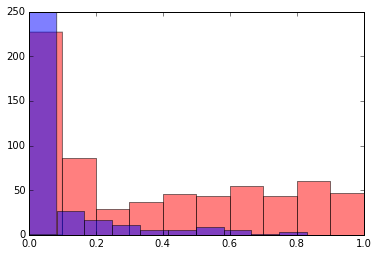

In [136]:
dist_y_test = data_y_test.dist.values

plt.hist(dist_y_test[(labels_y_test==2)*(dist_y_test <= 1)], label='2', color='r', alpha=0.5)
plt.hist(dist_y_test[(labels_y_test==1)*(dist_y_test <= 1)], label='1', color='b', alpha=0.5)
plt.ylim(0, 250)
plt.show()

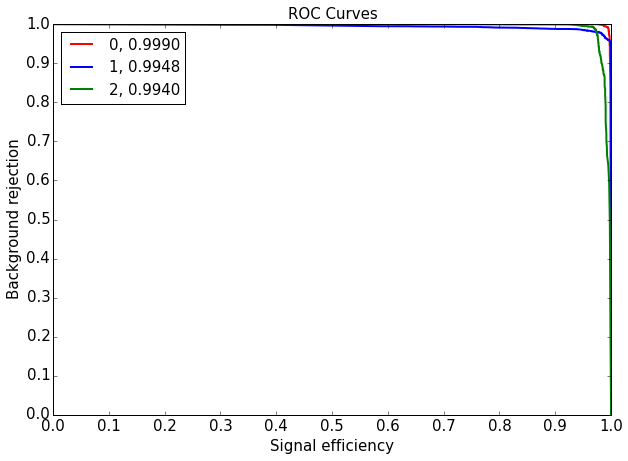

In [107]:
import os, sys
sys.path.append('../python')
import utils

utils.get_roc_curves(labels_y_test, probas_y_test, ['0', '1', '2'], save_path=None, show=True)

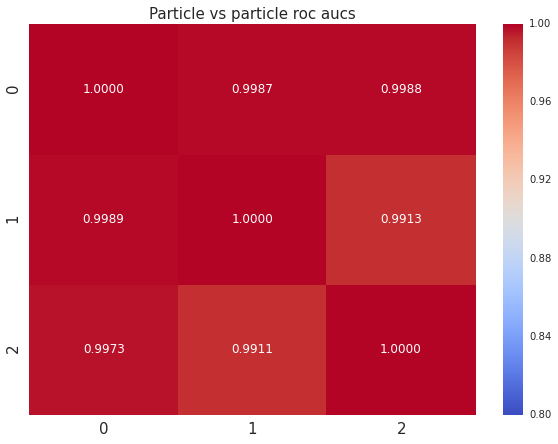

,0,1,2
0,1.000000,0.998739,0.998781
1,0.998937,1.000000,0.991295
2,0.997326,0.991141,1.000000


In [108]:
roc_auc_matrix = utils.get_roc_auc_matrix(labels_y_test, probas_y_test, ['0', '1', '2'], save_path=None, show=True)
roc_auc_matrix

In [109]:
import cPickle as pickle

clf_pickle = open('classifier_y.pkl', 'wb')
pickle.dump(clf_y, clf_pickle)
clf_pickle.close()

In [110]:
# import cPickle as pickle

# clf_pickle2 = open('classifier_y.pkl', 'rb')
# clf_y = pickle.load(clf_pickle2)
# clf_pickle2.close()

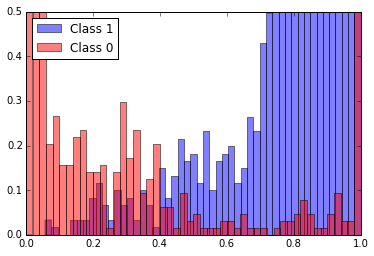

In [155]:
proba = clf_y.predict_proba(data_y_test[all_cols].values)[:, 1]
y_test = data_y_test[['label']].values

plt.hist(proba[y_test.reshape(-1)==1], color="blue", label="Class 1", normed=True, alpha=0.5, bins=50)
plt.hist(proba[y_test.reshape(-1)==2], color="red", label="Class 0", normed=True, alpha=0.5, bins=50)
plt.ylim(0, 0.5)
plt.legend(loc="upper left")

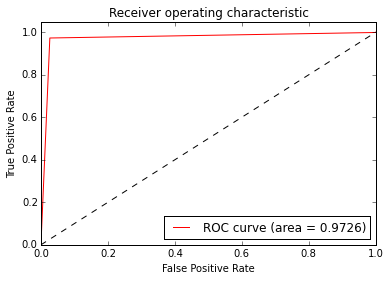

In [112]:
y_score = clf_y.predict(data_y_test[all_cols].values)

fpr, tpr, thresholds = metrics.roc_curve(y_test.reshape(-1)[y_test.reshape(-1) != 0], y_score[y_test.reshape(-1) != 0], pos_label=2)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [113]:
from sklearn.metrics import accuracy_score, classification_report

report = classification_report(y_test.reshape(-1), y_score)
print report

             precision    recall  f1-score   support

          0       1.00      0.99      0.99      3204
          1       0.96      0.97      0.97      3204
          2       0.97      0.97      0.97      3204

avg / total       0.98      0.98      0.98      9612



# Train classifier for stereo views

In [114]:
weights_stereo = numpy.zeros(len(data_stereo['label'].values))

for one_lab in [0, 1, 2]:
    
    weights_stereo += 0.1 * (data_stereo['label'].values == one_lab) * len(data_stereo['label'].values) / ((data_stereo['label'].values == one_lab).sum())
    
numpy.unique(weights_stereo)

array([ 0.29050786,  0.30012492,  0.31      ])

In [115]:
%%time

clf_stereo = RandomForestClassifier(n_estimators=1000, 
                             max_features='auto', 
                             max_depth=None, 
                             bootstrap=False, 
                             class_weight='balanced',
                             n_jobs = 3,
                             criterion = 'gini',
                             min_samples_leaf = 1)

clf_stereo.fit(data_stereo[all_cols].values, data_stereo[['label']].values, weights_stereo)

CPU times: user 20.6 s, sys: 312 ms, total: 20.9 s
Wall time: 8.87 s


/Users/mikhail91/.virtualenvs/rep_6_5/lib/python2.7/site-packages/ipykernel/__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [116]:
import cPickle as pickle

clf_pickle = open('classifier_stereo.pkl', 'wb')
pickle.dump(clf_stereo, clf_pickle)
clf_pickle.close()

In [117]:
# import cPickle as pickle

# clf_pickle2 = open('classifier_stereo.pkl', 'rb')
# clf_stereo = pickle.load(clf_pickle2)
# clf_pickle2.close()

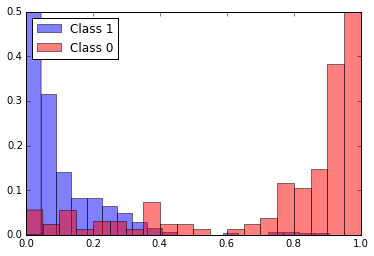

In [152]:
proba = clf_stereo.predict_proba(data_stereo_test[all_cols].values)[:, 0]
y_test = data_stereo_test[['label']].values

plt.hist(proba[y_test.reshape(-1)!=0], color="blue", label="Class 1", normed=True, alpha=0.5, bins=20)
plt.hist(proba[y_test.reshape(-1)==0], color="red", label="Class 0", normed=True, alpha=0.5, bins=20)
plt.ylim(0, 0.5)
plt.legend(loc="upper left")

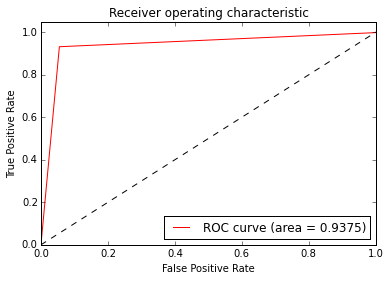

In [119]:
y_score = clf_stereo.predict(data_stereo_test[all_cols].values)

fpr, tpr, thresholds = metrics.roc_curve(y_test.reshape(-1)[y_test.reshape(-1) != 0], y_score[y_test.reshape(-1) != 0], pos_label=2)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [120]:
from sklearn.metrics import accuracy_score, classification_report

report = classification_report(y_test.reshape(-1), y_score)
print report

             precision    recall  f1-score   support

          0       1.00      0.98      0.99      3245
          1       0.93      0.94      0.94      3125
          2       0.93      0.93      0.93      3125

avg / total       0.95      0.95      0.95      9495



In [121]:
labels_stereo_test = data_stereo_test[['label']].values.reshape(-1)
probas_stereo_test = clf_stereo.predict_proba(data_stereo_test[all_cols].values)

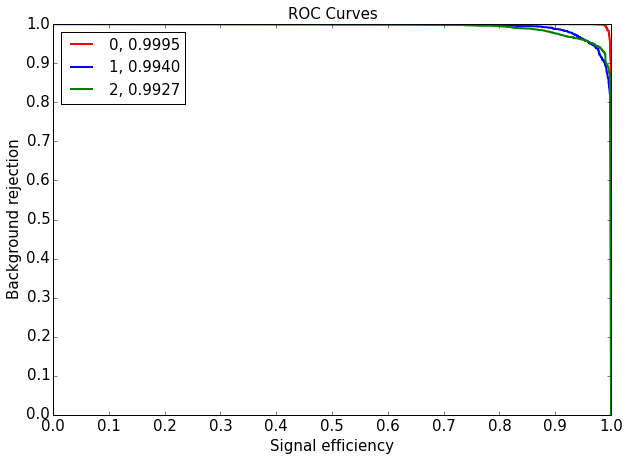

In [122]:
import os, sys
sys.path.append('../python')
import utils

utils.get_roc_curves(labels_stereo_test, probas_stereo_test, ['0', '1', '2'], save_path=None, show=True)

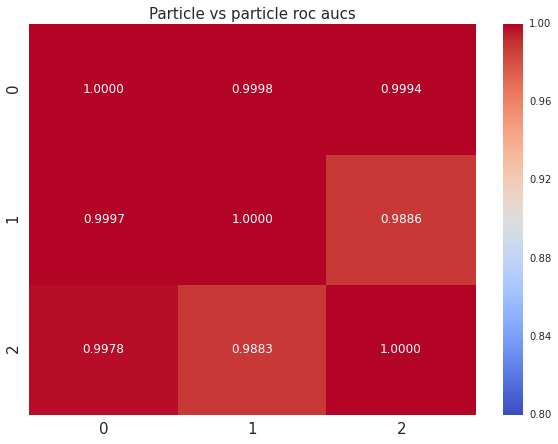

,0,1,2
0,1.000000,0.999798,0.999446
1,0.999696,1.000000,0.988585
2,0.997751,0.988337,1.000000


In [123]:
roc_auc_matrix = utils.get_roc_auc_matrix(labels_stereo_test, probas_stereo_test, ['0', '1', '2'], save_path=None, show=True)
roc_auc_matrix